In [1]:
%matplotlib inline

## Calibration

This notebook demonstrates how the user might calibrate the model to a multiple gauging stations. <br>
The default approach in the AWRACMS is to calibrate multiple catchments to a single set of parameters.

This notebook goes through the following steps:

1. Import required libraries
2. Set up calibration configuration <br>
 2.1 Catchments to be calibrated<br>
 2.2 Period to calibrate over<br>
 2.3 Define forcing and observation inputs<br>
 2.4 Select Optimiser, e,g sce<br>
 2.5 Define objective functions<br>
 2.6 Combine into a specification dictionary<br>
3. Run model calibration<br>
4. Extract best parameter set<br>
5. Visualise calibration process outputs<br>
6. Exercises


### 1. Import required libraries

In [2]:
import pandas as pd
from os.path import join
import h5py

from awrams.models.awral.model import AWRALModel
from awrams.models.settings import TRAINING_DATA_PATH

from awrams.utils.nodegraph import nodes, graph

from awrams.utils import gis
from awrams.utils import datetools as dt
from awrams.utils import extents
from awrams.utils.settings_manager import get_settings
from awrams.utils.gis import ShapefileDB, CATCHMENT_SHAPEFILE

from awrams.calibration.optimizers import sce
from awrams.calibration.objectives import test_objectives as tobj
from awrams.calibration.support import *
from awrams.calibration import cluster
from awrams.calibration.launch_calibration import run_from_pickle

from matplotlib import pyplot as plt

In [3]:
# Instantiate the AWRA-L model

awral = AWRALModel()

### 2. Define calibration configuration

#### 2.1 Pick a catchment from the default catchments dataset

In [4]:
calvalshapefile = ShapefileDB(CATCHMENT_SHAPEFILE)

# Define the extenst of the calibration
def_extent = extents.get_default_extent() 

In [5]:
CATCHMENT_SHAPEFILE

'/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/utils/data/Final_list_all_attributes.shp'

In [6]:
# Single catchment
#my_extent = calvalshapefile.get_extent_by_field('StationID', '003303', parent_extent=def_extent)
#my_extent

In [7]:
#from awrams.calibration.launch_calibration import run_from_pickle
#run_from_pickle('./test_cal.pkl')

In [8]:
 ## Create a dict with multiple extents
cal_dict = {}
cal_catchments = ['105001','145003']

for catchment in cal_catchments:
    cal_dict[catchment] = calvalshapefile.get_extent_by_field('StationID', catchment.zfill(6), parent_extent=def_extent)
    
cal_dict
  

{'105001': origin: -15.2,143.6, shape: (9, 8), cell_size: 0.05,
 '145003': origin: -28.2,152.6, shape: (4, 5), cell_size: 0.05}

/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/visualisation/vis.py:82: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  to_plot.data[c_ext.indices][c_ext.mask==False] = 2.0


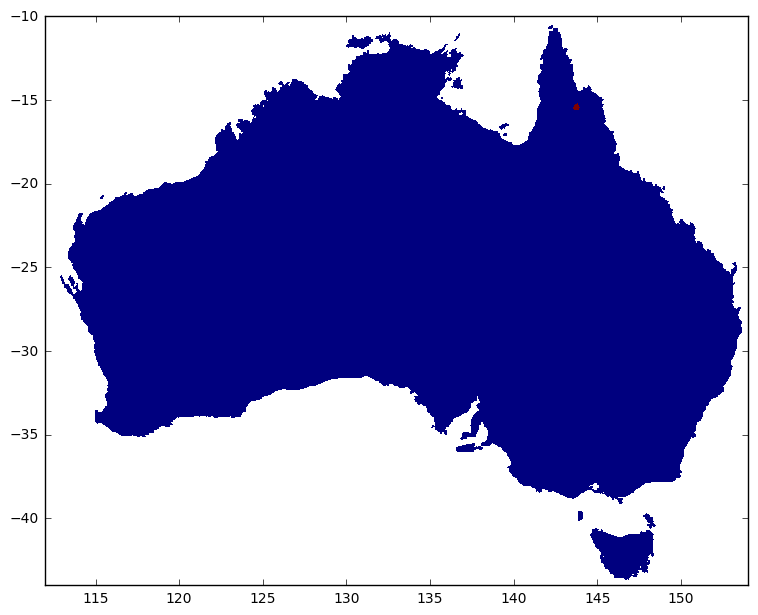

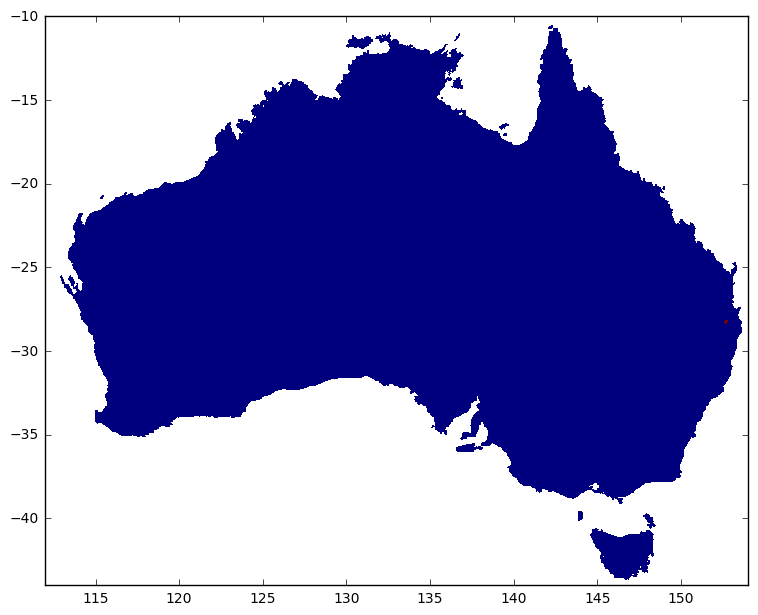

In [9]:
## Check out where the catchments are

import awrams.visualisation.vis as vis
import awrams.visualisation.results as res

import awrams.utils.extents as extents

vis.show_extent(cal_dict['105001'],def_extent)
vis.show_extent(cal_dict['145003'],def_extent)

#### 2.2 Specify running and calibration period

In [10]:
run_period = dt.dates('2009 - 2010')
eval_period = dt.dates('2009 - 2010')

#### 2.3 Specify forcing inputs and observations

In [11]:
# 2.3.1 Specify observation location

#observations_df = pd.read_csv('../test_data/calibration/q_obs.csv', index_col=[0],parse_dates=True)
observations = dict(qtot = '../../test_data/calibration/q_obs.csv' )
#observations=dict(qtot=join(paths.OBS_PATH,'qobs_zfill.csv'))

In [12]:
## 2.3.2 Check model inputs
#from awrams.models import awral
#from awrams.utils.nodegraph import nodes, graph

def change_path_to_forcing(imap):
    from awrams.utils.nodegraph import nodes
    from os.path import join
    from os import getcwd

    # data_path = '../../test_data/calibration/' [This path to be reonfigured to place forcings in separate folders]
    data_path = TRAINING_DATA_PATH + 'climate/BOM_climate/'
    
    FORCING = {
        'tmin': ('temp_min*.nc','temp_min_day',data_path + 'temp_min_day/'),
        'tmax': ('temp_max*.nc','temp_max_day',data_path + 'temp_max_day/'),
        'precip': ('rain_day*.nc','rain_day',data_path + 'rain_day/'),
        'solar': ('solar*.nc','solar_exposure_day',data_path + 'solar_exposure_day/') #,

    }
    for k,v in FORCING.items():
        imap[k+'_f'] = nodes.forcing_from_ncfiles(v[2],v[0],v[1])

In [13]:
input_map = awral.get_default_mapping()

In [14]:
change_path_to_forcing(input_map)

2009 contains missing solar radation, so will need to infill if you want to run that year. The [SimulationServer] notebook has an example of how to do that.
[SimulationServer]: ../Simulation/SimulationServer.ipynb


In [15]:
## there are gaps to solar data in 2009, infill the dataset.
def insert_solar_climatology(imap):
    from awrams.utils.nodegraph import nodes
    # from awrams.models.settings import CLIMATOLOGIES
    CLIMATOLOGIES = {'solar': (TRAINING_DATA_PATH + '/simulation/climatology/Rad_1990_2009.nc', 'solar_exposure_day')}
   
    imap = imap.copy()
    
    imap['solar_f_orig'] = imap['solar_f'] #'Move' the forcing node to a new name
    imap['solar_climatology_f'] = nodes.monthly_climatology(*CLIMATOLOGIES['solar']) # Loads monthly climatology from default file

    # Replace 'solar_f' with infilled data
    # This ensures that any other nodes in the graph who use solar_f as input will automatically receive the infilled data
    # nodes.gap_filler takes the first argument as 'gappy' data, and in infills with data from the second argument
    imap['solar_f']  = nodes.gap_filler('solar_f_orig','solar_climatology_f')
    
    return imap

In [16]:
input_map = insert_solar_climatology(input_map)

#### 2.4 Select optimiser

In [17]:
#[Using alternative optimizers is an advanced functionality that we might go through later]

#from awrams.calibration.optimizers import sce

 - The **Shuffled-Complex evolution (SCE)** algorithm of Duan et al (1993) is used for finding and optimum parameter set 
     - Duan, Q.Y., Gupta, V.K. & Sorooshian, S. J Optim Theory Appl (1993) 76: 501. https://doi.org/10.1007/BF00939380

In [18]:
evolver_spec = EvolverSpec(sce.CCEvolver,
                           evolver_run_args=dict(n_offspring=1,n_evolutions=5,elitism=2.0))

optimizer_spec = OptimizerSpec(sce.ShuffledOptimizer,
                               evolver_spec=evolver_spec,
                               n_complexes=5,
                               max_nsni=500,
                               min_complexes=1,
                               max_eval=2000) #n_complex 14

#### 2.5 Import objective function

In [19]:
#from awrams.calibration.objectives import test_objectives as tobj

In [20]:
# %load ../../calibration/awrams/calibration/objectives/test_objectives.py
from awrams.calibration.objectives import *
from awrams.calibration.support import input_group
import numpy as np

obs = np.linspace(0.,1.,365)

def test_nse():
	nse = NSE(obs)
	assert( nse(obs) == 1.0 )
	assert( nse(np.repeat(obs.mean(),365)) == 0.0 )

def test_bias():
	bias = Bias(obs)
	assert( bias(obs) == 0.0 )
	assert( bias(obs*2.0) == 1.0 )

class LocalQTotal:
    '''
    Simple sum of run
    '''

    #input_schema = ['qtot','etot','dd']
    input_schema = input_group(['qtot','etot','dd'],'volume')
    output_schema = ['qtot_vol','etot_vol','dd_vol']

    def __init__(self,obs,eval_period):
        pass

    def evaluate(self,modelled):
        return np.array((np.sum(modelled['qtot']),np.sum(modelled['etot']),np.sum(modelled['dd'])))

class GlobalQTotal:

    output_schema = ['qtot_vol','etot_vol','dd_vol']
    objective_key = 'qtot_vol'

    def evaluate(self,l_results):
        out_d = dict( [(k, np.sum(l_results[k])) for k in self.output_schema] )
        return out_d

class TestLocalSingle:

    input_schema = input_group(['qtot'])
    output_schema = ['qtot_nse']

    def __init__(self,obs,eval_period,min_valid=15):

        self.valid_idx = {}
        self.nse = {}
        self.flow_variable = 'qtot'
        for k in [self.flow_variable]:

            data = obs[k]

            if np.isnan(data).any():
                nan_mask = np.isnan(data)
                self.valid_idx[k] = np.where(nan_mask == False)
            else:
                self.valid_idx[k] = slice(0,len(eval_period))

            self.nse[k] = NSE(data[self.valid_idx[k]])

    def evaluate(self,modelled):
        qtot_nse = self.nse[self.flow_variable](modelled[self.flow_variable][self.valid_idx[self.flow_variable]])
        return np.array(qtot_nse)

class TestGlobalSingle:

    output_schema = ['objf_val']
    objective_key = 'objf_val'

    def evaluate(self,l_results):
        objf_val = 1.0 - np.mean(l_results['qtot_nse'])
        return dict(objf_val = objf_val)

class TestLocalMulti:

    input_schema = input_group(['qtot','etot'])
    output_schema = ['qtot_nse','etot_nse']

    def __init__(self,obs,eval_period,min_valid=15,flow_variable='qtot_avg',et_variable='etot_avg'):

        self.valid_idx = {}
        self.nse = {}

        self.flow_variable = flow_variable
        self.et_variable = et_variable
        
        for k in [flow_variable,et_variable]:

            data = obs[k]

            if np.isnan(data).any():
                nan_mask = np.isnan(data)
                self.valid_idx[k] = np.where(nan_mask == False)
            else:
                self.valid_idx[k] = slice(0,len(eval_period))

            self.nse[k] = NSE(data[self.valid_idx[k]])

    def evaluate(self,modelled):
        qtot_nse = self.nse[self.flow_variable](modelled[self.flow_variable][self.valid_idx[self.flow_variable]])
        etot_nse = self.nse[self.et_variable](modelled[self.et_variable][self.valid_idx[self.et_variable]])
        return dict(qtot_nse=qtot_nse,etot_nse=etot_nse)

class TestGlobalMultiEval:

    output_schema = ['objf_val','qtot_nse','etot_nse']
    objective_key = 'objf_val'

    def evaluate(self,l_results):
        qtot_nse = np.mean(l_results['qtot_nse'])
        etot_nse = np.mean(l_results['etot_nse'])
        objf_val = 1.0 - (qtot_nse+etot_nse) * 0.5
        #return 1.0 - np.mean((l_results['qtot_nse'] + l_results['etot_nse']) * 0.5)
        return dict(objf_val = objf_val, qtot_nse=qtot_nse, etot_nse=etot_nse)


In [21]:
local_objfspec = ObjectiveFunctionSpec(tobj.TestLocalSingle)  # this function to load up the ObjFunc comes from awrams.calibration.support
global_objfspec = tobj.TestGlobalSingle

In [22]:
objective_spec = ObjectiveSpec(global_objfspec,
                               local_objfspec,
                               observations,
                               eval_period)

#### 2.6. Build spec dict

Assemble above settings into specification dictionary

In [23]:
# Get the input mapping and model
node_mapping = input_map
model = awral#callable_to_funcspec(awral)

In [24]:
# Create the calibration specification dictionary

'''
User specifiable calibration description
'''
cal_spec = {}
cal_spec['optimizer_spec'] = optimizer_spec
cal_spec['objective_spec'] = objective_spec
cal_spec['extent_map'] = cal_dict
cal_spec['run_period'] = run_period
cal_spec['model'] = model
cal_spec['node_mapping'] = node_mapping
cal_spec['logfile'] = './calres.h5'



In [25]:
# Save a file containing all the calibration specifications

#import sys
#from awrams.calibration import cluster

cluster.build_pickle_from_spec(cal_spec,1,'test_cal.pkl')


{'catch_node_map': {'105001': [0], '145003': [0]},
 'extent_map': {'105001': origin: -15.2,143.6, shape: (9, 8), cell_size: 0.05,
  '145003': origin: -28.2,152.6, shape: (4, 5), cell_size: 0.05},
 'logfile': './calres.h5',
 'model': <awrams.models.awral.model.AWRALModel at 0x7fb56a0aa898>,
 'n_workers': 1,
 'node_alloc': OrderedDict([(0,
               {'catchments': [('105001',
                  {'ncells': 49, 'start_cell': 0},
                  {'owns': True, 'remote': False}),
                 ('145003',
                  {'ncells': 16, 'start_cell': 0},
                  {'owns': True, 'remote': False})],
                'cell_counts': [49, 16]})]),
 'node_mapping': {'alb_dry_hrudr': parameter([]):{'fixed': True, 'min': 0.1, 'max': 0.5, 'value': 0.26},
  'alb_dry_hrusr': parameter([]):{'fixed': True, 'min': 0.1, 'max': 0.5, 'value': 0.26},
  'alb_wet_hrudr': parameter([]):{'fixed': True, 'min': 0.1, 'max': 0.5, 'value': 0.16},
  'alb_wet_hrusr': parameter([]):{'fixed': True, 'min':

### 3. Run the calibration

In [26]:
#import mpi4py
#from awrams.calibration.launch_calibration import run_from_pickle

cal = run_from_pickle('./test_cal.pkl')

n
s:  1975

 evaluating initial population
{}
...
 running
{'n_eval': 264, 'n_shuffle': 2, 'best_params': Score: 0.787215807067, Params: [ 0.03941318  0.03789217  0.07214855  0.82408072  0.92199983  0.96857639
  3.08393983  1.5451794   2.00603256  0.049638    0.46869477  8.9847855
  0.47285554  2.04910222  1.67613136  0.34570536  0.34886143  0.62934172
  0.12895572  1.62575523  1.93201036], Meta: None}

 running
{'n_eval': 336, 'n_shuffle': 8, 'best_params': Score: 0.787215807067, Params: [ 0.03941318  0.03789217  0.07214855  0.82408072  0.92199983  0.96857639
  3.08393983  1.5451794   2.00603256  0.049638    0.46869477  8.9847855
  0.47285554  2.04910222  1.67613136  0.34570536  0.34886143  0.62934172
  0.12895572  1.62575523  1.93201036], Meta: None}

 running
{'n_eval': 388, 'n_shuffle': 14, 'best_params': Score: 0.787215807067, Params: [ 0.03941318  0.03789217  0.07214855  0.82408072  0.92199983  0.96857639
  3.08393983  1.5451794   2.00603256  0.049638    0.46869477  8.9847855
  0

### 4. Extract best parameter set

The calibration process creates a file containing all the parameters and objective scores of each iteration of the calibration.

In [27]:
cr = CalibrationResults('./calres.h5')

In [28]:
# These are the parameters we calibrated against

cr.parameter_names

['cgsmax_hrudr',
 'cgsmax_hrusr',
 'er_frac_ref_hrudr',
 'fsoilemax_hrudr',
 'fsoilemax_hrusr',
 'k0sat_scale',
 'k_gw_scale',
 'k_rout_int',
 'k_rout_scale',
 'kdsat_scale',
 'kr_coeff',
 'kssat_scale',
 'ne_scale',
 'pref_gridscale',
 's0max_scale',
 's_sls_hrudr',
 's_sls_hrusr',
 'sdmax_scale',
 'slope_coeff',
 'ssmax_scale',
 'ud0_hrudr']

In [29]:
# Get a DataFrame of the parameter values over time (iterations)

params_all = cr.get_parameter_values()

In [30]:
# Obtain the best (minimum score) parameter set
# Note that CalibrationResults.get_best_paramset() performs the same function

best_params = params_all.iloc[cr.best_param_index()]
best_params

#best_params.to_csv('cal_params_test.csv')

cgsmax_hrudr         0.020237
cgsmax_hrusr         0.032958
er_frac_ref_hrudr    0.066848
fsoilemax_hrudr      0.906176
fsoilemax_hrusr      0.980338
k0sat_scale          6.067147
k_gw_scale           0.808467
k_rout_int           2.585721
k_rout_scale         0.760175
kdsat_scale          0.023155
kr_coeff             0.575623
kssat_scale          0.467066
ne_scale             0.859348
pref_gridscale       2.923311
s0max_scale          2.314816
s_sls_hrudr          0.044190
s_sls_hrusr          0.454831
sdmax_scale          0.906147
slope_coeff          0.745054
ssmax_scale          1.177899
ud0_hrudr            1.783924
Name: 1999, dtype: float64

### 5. Take a look at the calibration outputs

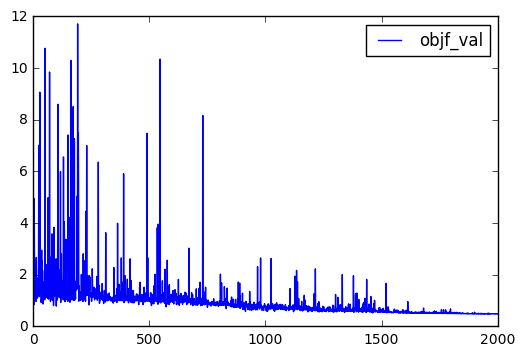

In [31]:
# Examine the change in global objective function values over time

gscores = cr.get_global_scores()
gscores.plot()

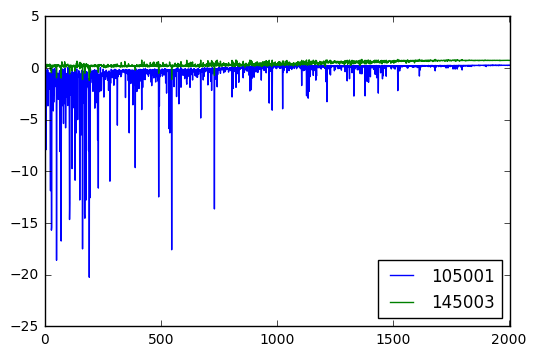

In [32]:
#Get some local (catchment level) scores

qnse_l = cr.get_local_scores('qtot_nse')
qnse_l.plot()

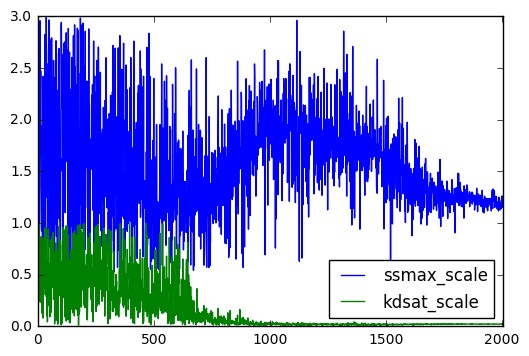

In [33]:
#Observe the evolution in parameter values over iterations
#Great for examining behaviour of parameter space for different optimizers!

params_all[['ssmax_scale','kdsat_scale']].plot()

### 6. Compare modelled and observed outputs

In [34]:
#Load up an OnDemand simulator to run the model

from awrams.simulation import ondemand

sim = ondemand.OnDemandSimulator(model,node_mapping)

In [35]:
# Load observations for comparison

obs_df = pd.DataFrame.from_csv(observations['qtot'])

In [36]:
# Set the new (calibrated) parameters

sim.input_runner.set_parameters(best_params)

In [37]:
sim_res = sim.run(run_period,cal_dict['105001'])

In [50]:
pd.DataFrame(sim_res['dd'])

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,1.074310,1.379962,0.685374,0.526254,0.757296,0.852266,0.950933,1.083355,0.281480,0.310935,...,0.588757,0.498364,0.621599,0.432580,0.769831,0.293775,0.491163,0.735955,0.513316,1.377108
1,1.192790,1.454059,0.713598,0.572620,0.786547,0.886568,0.995480,1.135965,0.300146,0.317416,...,0.613692,0.515190,0.648300,0.447760,0.865026,0.316781,0.508206,0.769268,0.531563,1.463029
2,1.337412,1.539309,0.745928,0.630527,0.821306,0.927490,1.042369,1.192217,0.324634,0.325613,...,0.638502,0.532781,0.675918,0.464392,0.963238,0.344406,0.525537,0.802260,0.550666,1.543816
3,1.450011,1.610739,0.777253,0.683882,0.853941,0.965062,1.088020,1.245104,0.349354,0.334093,...,0.666988,0.552977,0.706886,0.483240,1.067525,0.376269,0.545714,0.839670,0.572729,1.628123
4,1.608545,1.699962,0.814724,0.754815,0.894237,1.011866,1.139251,1.305417,0.382215,0.344886,...,0.696579,0.574751,0.740536,0.504736,1.186122,0.415543,0.566889,0.878673,0.596819,1.714390
5,1.712255,1.769695,0.846142,0.808945,0.928653,1.052025,1.180533,1.353941,0.409912,0.354986,...,0.723037,0.594867,0.771469,0.525306,1.288756,0.454833,0.586957,0.915105,0.620354,1.793375
6,1.793457,1.827409,0.876715,0.858125,0.960220,1.087783,1.221124,1.399886,0.436688,0.365016,...,0.752800,0.617503,0.805393,0.547996,1.398302,0.497260,0.610015,0.956052,0.647000,1.878287
7,1.866924,1.880808,0.905235,0.903401,0.990216,1.121622,1.258111,1.441479,0.462302,0.375038,...,0.780918,0.639217,0.837311,0.569666,1.494126,0.538058,0.632191,0.994520,0.672648,1.952990
8,1.967535,1.940483,0.940503,0.964289,1.025176,1.159736,1.306872,1.494705,0.496376,0.386957,...,0.822822,0.669894,0.881645,0.598736,1.636655,0.590397,0.663398,1.047633,0.706483,2.050515
9,2.091236,2.006509,0.979283,1.033014,1.062718,1.200293,1.358375,1.550532,0.533566,0.399831,...,0.863430,0.700231,0.924849,0.627356,1.763853,0.641617,0.694254,1.098611,0.739771,2.139004


In [ ]:
#sim_res.to_csv('/data/cwd_awra_data/AWRACMS/Training/test_data/105001sim.csv')

In [51]:
#Simulations output gridded data; get some convenience aggregation functions

from awrams.calibration.support import aggregate, flattened_areas

def mean_by_extent(in_data,extent):
    weights = flattened_areas(extent)
    return aggregate(in_data,weights,weights.sum())

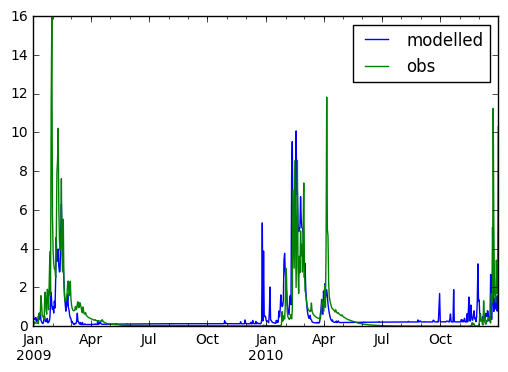

In [52]:
comp_df = pd.DataFrame()
comp_df['modelled'] = pd.Series(mean_by_extent(sim_res['qtot'],cal_dict['105001']),index=run_period)
comp_df['obs'] = obs_df['105001'][run_period]
comp_df.plot()

In [53]:
# Deliberately get the worst parameter set, just to see how bad it is...

worst_params = cr.get_best_paramset(reverse=True)

In [54]:
sim.input_runner.set_parameters(worst_params)
bad_res = sim.run(run_period,cal_dict['105001'])

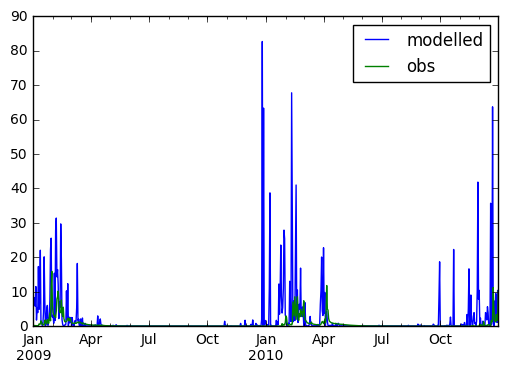

In [55]:
comp_df = pd.DataFrame()
comp_df['modelled'] = pd.Series(mean_by_extent(bad_res['qtot'],cal_dict['105001']),index=run_period)
comp_df['obs'] = obs_df['105001'][run_period]
comp_df.plot()

## Exercise A
#### Re-calibrate to only one catchment
#### Use the parameters from the two calibrations in 2 ondemand simulations for the set of catchments
#### Compare flows from the models to the observations

## Exercise B

The [Putting_it_all_in_practice] workbook in the Training/Workspace folder where the steps are outlined in a bit more detail.

#### Use the provided set of Tasmanian catchments and repeat the calibration process.

#### Follow it up by doing some benchmarking, visualisation in the following session

[Putting_it_all_in_practice]: ../Workspace/Putting_it_all_in_practice.ipynb